In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt_tab') # Download the missing resource
import string
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
plt.style.use('ggplot')
import warnings
warnings.simplefilter('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
import kagglehub
path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")
print("Path to dataset files:", path)

100%|██████████| 211k/211k [00:00<00:00, 1.29MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/uciml/sms-spam-collection-dataset/versions/1


In [4]:
df = pd.read_csv('/root/.cache/kagglehub/datasets/uciml/sms-spam-collection-dataset/versions/1/spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]  # Keep only the relevant columns
df.rename(columns={'v1':'Target', 'v2':'Messages'}, inplace=True)

In [5]:
print("\nFirst 5 rows of the dataset:")
display(df.head())


First 5 rows of the dataset:


,Target,Messages
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
message_counts = [df[df['Target']=='spam'].shape[0], df[df['Target']=='ham'].shape[0]]
labels = ['Spam', 'Ham']

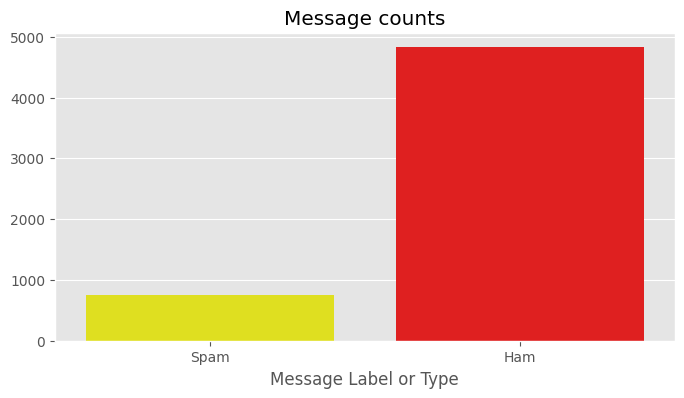

In [7]:
plt.figure(figsize=(8, 4))
plt.title('Message counts')
plt.xlabel('Message Label or Type')
sns.barplot(x=labels, y=message_counts, palette=['yellow', 'red'])
plt.show()

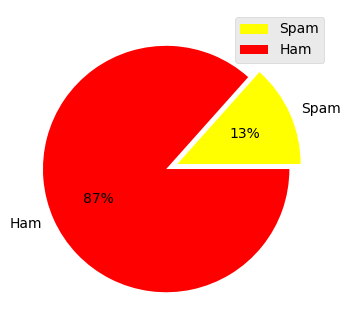

In [8]:
plt.figure(figsize=(8, 4))
plt.pie(x=message_counts, explode=[0, 0.1], labels=labels, autopct='%0.f%%', colors=['yellow', 'red'])
plt.legend()
plt.show()

In [9]:
encoder = LabelEncoder()
df['Target'] = encoder.fit_transform(df['Target'])

In [10]:
print("\nMissing values:")
print(df.isnull().sum())

print("\nNumber of duplicates before removal:", df.duplicated().sum())
df.drop_duplicates(keep='first', inplace=True)
print("Number of duplicates after removal:", df.duplicated().sum())


Missing values:
Target      0
Messages    0
dtype: int64

Number of duplicates before removal: 403
Number of duplicates after removal: 0


In [13]:
df['Num_characters'] = df['Messages'].apply(len)
df['Num_words'] = df['Messages'].apply(lambda x: len(nltk.word_tokenize(x)))
df['Num_sentences'] = df['Messages'].apply(lambda x: len(nltk.sent_tokenize(x)))


In [14]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))

    return " ".join(y)

df['Transformed_text'] = df['Messages'].apply(transform_text)


In [15]:
from wordcloud import WordCloud
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')


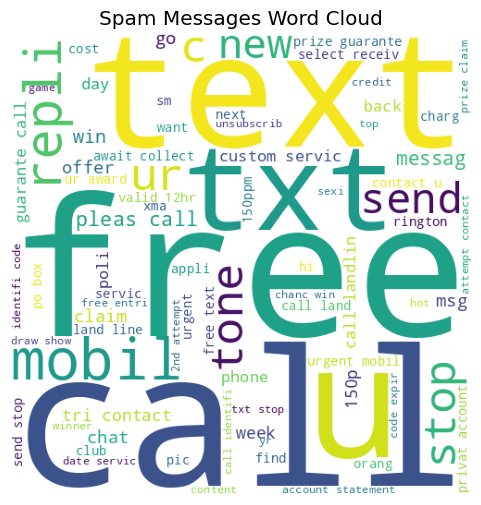

In [16]:
spam_wc = wc.generate(df[df['Target'] == 1]['Transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15, 6))
plt.imshow(spam_wc)
plt.title('Spam Messages Word Cloud')
plt.axis('off')
plt.show()


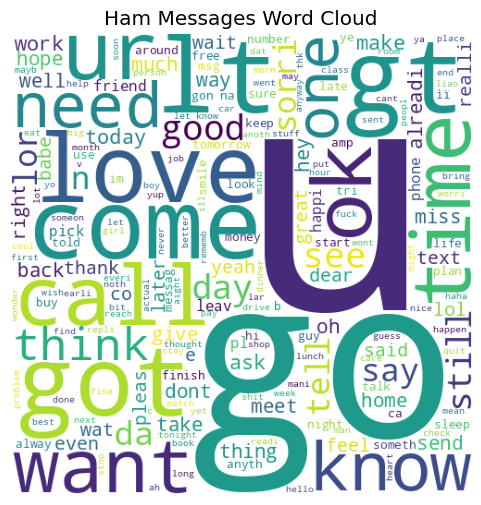

In [17]:
ham_wc = wc.generate(df[df['Target'] == 0]['Transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15, 6))
plt.imshow(ham_wc)
plt.title('Ham Messages Word Cloud')
plt.axis('off')
plt.show()

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score

tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['Transformed_text']).toarray()
y = df['Target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

svc = SVC(kernel='sigmoid', gamma=1.0, probability=True)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

print("\nModel Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))


Model Performance:
Accuracy: 0.9758220502901354
Precision: 0.9747899159663865
